In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization] pandas polars narwhals

# run me in google colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/narwhals/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/narwhals/notebook.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/narwhals/notebook.ipynb)

In [2]:
%load_ext hamilton.plugins.jupyter_magic

cannot import name 'PolarsDataType' from 'polars' (/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/polars/__init__.py)


/Users/stefankrawczyk/.pyenv/versions/knowledge_retrieval-py39/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [8]:
config = {
    "mode": "pandas"
}
from hamilton import driver
builder = driver.Builder()

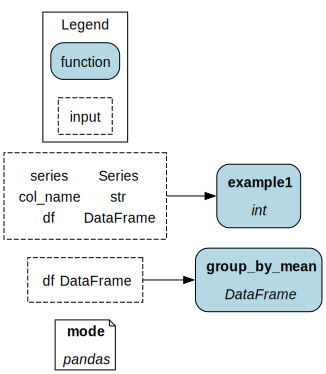

In [12]:
%%cell_to_module example --display --config '{"mode":"pandas"}'

import narwhals as nw
import pandas as pd
import polars as pl

from hamilton.function_modifiers import config, tag


@config.when(load="pandas")
def df__pandas() -> nw.DataFrame:
    return pd.DataFrame({"a": [1, 1, 2, 2, 3], "b": [4, 5, 6, 7, 8]})


@config.when(load="pandas")
def series__pandas() -> nw.Series:
    return pd.Series([1, 3])


@config.when(load="polars")
def df__polars() -> nw.DataFrame:
    return pl.DataFrame({"a": [1, 1, 2, 2, 3], "b": [4, 5, 6, 7, 8]})


@config.when(load="polars")
def series__polars() -> nw.Series:
    return pl.Series([1, 3])


@tag(nw_kwargs=["eager_only"])
def example1(df: nw.DataFrame, series: nw.Series, col_name: str) -> int:
    return df.filter(nw.col(col_name).is_in(series.to_numpy())).shape[0]


def group_by_mean(df: nw.DataFrame) -> nw.DataFrame:
    return df.group_by("a").agg(nw.col("b").mean()).sort("a")


In [18]:
from hamilton import base, driver
from hamilton.plugins import h_narwhals, h_polars
# pandas
dr = (
    driver.Builder()
    .with_config({"load": "pandas"})
    .with_modules(example)
    .with_adapters(
        h_narwhals.NarwhalsAdapter(),
        h_narwhals.NarwhalsDataFrameResultBuilder(base.PandasDataFrameResult()),
    )
    .build()
)
result = dr.execute([example.group_by_mean, example.example1], inputs={"col_name": "a"})
result

,group_by_mean.a,group_by_mean.b,example1
0,1,4.5,3
1,2,6.5,3
2,3,8.0,3


In [19]:
# polars
dr = (
    driver.Builder()
    .with_config({"load": "polars"})
    .with_modules(example)
    .with_adapters(
        h_narwhals.NarwhalsAdapter(),
        h_narwhals.NarwhalsDataFrameResultBuilder(h_polars.PolarsDataFrameResult()),
    )
    .build()
)
result= dr.execute([example.group_by_mean, example.example1], inputs={"col_name": "a"})
result

group_by_mean,example1
struct[2],i32
"{1,4.5}",3
"{2,6.5}",3
"{3,8.0}",3


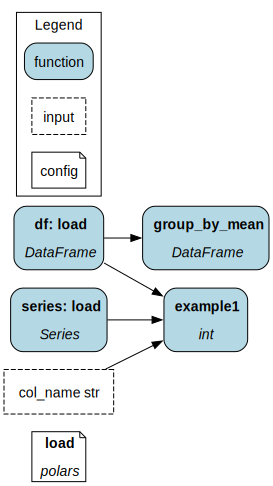

In [15]:
dr.display_all_functions()